# Sequence-to-sequence RNN

This notebook shows an example of a character-level sequence-to-sequence recurrent neural network model using Keras.

The implementation and example data draw on [A ten-minute introduction to sequence-to-sequence learning in Keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html) and [English to Katakana using a Sequence-to-Sequence model](https://github.com/wanasit/katakana)

## Configuration

The following variables configure a few aspects of the data, model, and training process. To adapt this example to a different dataset, you'll probably want to change these to match.

In [1]:
# Maximum number of examples to read
MAX_EXAMPLES = 100000

# Maximum length of input sequence in characters
INPUT_LENGTH = 20

# Maximum length of output sequence in characters
OUTPUT_LENGTH = 20

# Number of epochs to train for
EPOCHS = 8

# Training batch size
BATCH_SIZE = 64

# Size of character embeddings
EMBEDDING_DIM = 100

# Size of RNN states
RNN_UNITS = 100

## Download dataset

We'll be using the English to Japanese katakana characters dataset from [English to Katakana using a Sequence-to-Sequence model](https://github.com/wanasit/katakana).

In [2]:
!wget -nc https://raw.githubusercontent.com/wanasit/katakana/master/dataset/data.csv

File ‘data.csv’ already there; not retrieving.



## Load data

In [3]:
import random


def load_data(fn, separator=',', has_header_line=True, max_examples=None):
    data = []
    with open(fn) as f:
        if has_header_line:
            next(f)    # skip header
        for line in f:
            if max_examples is not None and len(data) >= max_examples:
                break
            line = line.rstrip('\n')
            input_text, output_text = line.split(separator)
            data.append([input_text, output_text])
    return data


data = load_data('data.csv', max_examples=MAX_EXAMPLES)

random.seed(1234)    # make random.shuffle() repeatable
random.shuffle(data)

input_texts = [input_text for input_text, output_text in data]
output_texts = [output_text for input_text, output_text in data]


# Have a look at the source data
for i in range(5):
    print(input_texts[i], '→', output_texts[i])

Paranthropus → パラントロプス
Jarret Martin → ジャレット・マーティン
Ildefons Lima → イルデフォンス・リマ・ソラ
Joseph Calleia → ジョセフ・カレイア
Rorschach → ロールシャッハ


## Vectorize text

Tokenize on the character level with lowercasing. To allow different input and output alphabets, create separate tokenizers for each.

We're slightly abusing the tokenizer's out-of-vocabulary item support here to introduce a special `<START>` token into the mapping. As we're not restricting the number of words, this token will never be output by the tokenizer, so we're free to use it for our purposes.

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer


input_tokenizer = Tokenizer(lower=True, char_level=True)
output_tokenizer = Tokenizer(lower=True, char_level=True, oov_token='<START>')

input_tokenizer.fit_on_texts(input_texts)
output_tokenizer.fit_on_texts(output_texts)

# Remember these
INPUT_VOCAB_SIZE = max(input_tokenizer.word_index.values()) + 1
OUTPUT_VOCAB_SIZE = max(output_tokenizer.word_index.values()) + 1
START_INDEX = output_tokenizer.word_index['<START>']

Let's have a look at those mappings.

In [5]:
from pprint import pprint    # pretty-printer


def truncate_dict(d, count=10):
    # Returns at most count items from the given dictionary.  
    return dict(i for i, _ in zip(d.items(), range(count)))


print('Number of entries in input mapping:', len(input_tokenizer.word_index))
pprint(truncate_dict(input_tokenizer.word_index))
print('Number of entries in output mapping:', len(output_tokenizer.word_index))
pprint(truncate_dict(output_tokenizer.word_index))

Number of entries in input mapping: 134
{' ': 7,
 'a': 1,
 'e': 2,
 'i': 5,
 'l': 8,
 'n': 4,
 'o': 6,
 'r': 3,
 's': 9,
 't': 10}
Number of entries in output mapping: 88
{'<START>': 1,
 'ア': 8,
 'ス': 6,
 'ト': 10,
 'ラ': 9,
 'リ': 7,
 'ル': 5,
 'ン': 4,
 '・': 3,
 'ー': 2}


Map input and output texts to integer sequences using the tokenizers, then pad and truncate the sequences to desired input and output lengths.

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


def vectorize(texts, tokenizer, maxlen, quiet=False):
    # This bit does the work
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen, padding='post')
    
    # This just prints out the first input and its vectorized versions
    if not quiet:
        print('Text:', texts[0])
        print('Sequence:', sequences[0])
        print('Padded:', padded[0])
        print('Mapped back:', [tokenizer.index_word.get(i, '-') for i in padded[0]])
    
    return padded


encoder_X = vectorize(input_texts, input_tokenizer, INPUT_LENGTH)
decoder_Y = vectorize(output_texts, output_tokenizer, OUTPUT_LENGTH)

# This creates numpy arrays:
print('type(encoder_X):', type(encoder_X))
print('encoder_X.shape:', encoder_X.shape)

Text: Paranthropus
Sequence: [19, 1, 3, 1, 4, 10, 13, 3, 6, 19, 15, 9]
Padded: [19  1  3  1  4 10 13  3  6 19 15  9  0  0  0  0  0  0  0  0]
Mapped back: ['p', 'a', 'r', 'a', 'n', 't', 'h', 'r', 'o', 'p', 'u', 's', '-', '-', '-', '-', '-', '-', '-', '-']
Text: パラントロプス
Sequence: [52, 9, 4, 10, 18, 48, 6]
Padded: [52  9  4 10 18 48  6  0  0  0  0  0  0  0  0  0  0  0  0  0]
Mapped back: ['パ', 'ラ', 'ン', 'ト', 'ロ', 'プ', 'ス', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
type(encoder_X): <class 'numpy.ndarray'>
encoder_X.shape: (100000, 20)


In prediction, the decoder will receive its last output as input at each timestep. During training, we'll use _teacher forcing_, where the decoder is instead given the correct previous output. To implement this, the output sequence (`decoder_Y`) is shifted one character forward, and the special start symbol is placed first in the sequence.

In [7]:
import numpy as np


decoder_X = np.zeros_like(decoder_Y)
decoder_X[:,1:] = decoder_Y[:,:-1]
decoder_X[:,0] = START_INDEX

print('decoder_X:', decoder_X[0])
print('Mapped back:', [output_tokenizer.index_word.get(i, '-') for i in decoder_X[0]])
print('decoder_Y:', decoder_Y[0])
print('Mapped back:', [output_tokenizer.index_word.get(i, '-') for i in decoder_Y[0]])

decoder_X: [ 1 52  9  4 10 18 48  6  0  0  0  0  0  0  0  0  0  0  0  0]
Mapped back: ['<START>', 'パ', 'ラ', 'ン', 'ト', 'ロ', 'プ', 'ス', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
decoder_Y: [52  9  4 10 18 48  6  0  0  0  0  0  0  0  0  0  0  0  0  0]
Mapped back: ['パ', 'ラ', 'ン', 'ト', 'ロ', 'プ', 'ス', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']


Convert output integer values standing for vocabulary items (characters) into a one-hot representation for training.

In [8]:
from tensorflow.keras.utils import to_categorical


one_hot_decoder_Y = to_categorical(decoder_Y)

print('decoder_Y[0][0]:', decoder_Y[0][0])
print('one_hot_decoder_Y[0][0]:')
print(one_hot_decoder_Y[0][0])
print('one_hot_decoder_Y[0][0].argmax():', one_hot_decoder_Y[0][0].argmax())

decoder_Y[0][0]: 52
one_hot_decoder_Y[0][0]:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
one_hot_decoder_Y[0][0].argmax(): 52


## Build model

Note the following:

* `mask_zero=True` for the embedding makes the model ignore padding (see [Masking and padding with Keras](https://www.tensorflow.org/guide/keras/masking_and_padding))
* `return_state=True` for the encoder RNN returns the state of the last timestep in addition to output (see https://keras.io/layers/recurrent/).
* As we're using an LSTM, we get two separate state values, _h_ and _c_ (see below)
* `return_sequences=True` for the decoder RNN returns the output from each time step, not only the last

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" style="width: 50%">

(LSTM illustration from https://colah.github.io/posts/2015-08-Understanding-LSTMs/ )


In [9]:
from tensorflow.keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense
from tensorflow.keras.models import Model, load_model


def build_seq2seq_model(input_length, output_length,
                        input_vocab_size, output_vocab_size,
                        embedding_dim=EMBEDDING_DIM, rnn_units=RNN_UNITS):
    encoder_input = Input(shape=(input_length,))
    encoder_embedding = Embedding(input_vocab_size, embedding_dim, mask_zero=True)(encoder_input)
    encoder_output, encoder_h, encoder_c = LSTM(
        rnn_units,
        return_sequences=False,
        return_state=True,
        unroll=True
    )(encoder_embedding)
    encoder_states = [encoder_h, encoder_c]

    decoder_input = Input(shape=(output_length,))
    decoder_embedding = Embedding(output_vocab_size, embedding_dim, mask_zero=True)(decoder_input)
    decoder_rnn = LSTM(rnn_units, return_sequences=True, unroll=True)(
        decoder_embedding,
        initial_state=encoder_states
    )
    decoder_output = TimeDistributed(Dense(output_vocab_size, activation="softmax"))(decoder_rnn)

    model = Model(inputs=[encoder_input, decoder_input], outputs=[decoder_output])
    return model


model = build_seq2seq_model(
    input_length=INPUT_LENGTH,
    output_length=OUTPUT_LENGTH,
    input_vocab_size=INPUT_VOCAB_SIZE,
    output_vocab_size=OUTPUT_VOCAB_SIZE
)

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 100)      13500       input_1[0][0]                    

## Training

As we have one-hot encoded our outputs, we'll use `categorical_crossentropy` loss.

In [10]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy'
)

In [11]:
history = model.fit(
    x=[encoder_X, decoder_X], 
    y=[one_hot_decoder_Y],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)

Train on 80000 samples, validate on 20000 samples
Epoch 1/8
80000/80000 [==============================] - 110s 1ms/sample - loss: 1.3737 - val_loss: 1.1209
Epoch 2/8
80000/80000 [==============================] - 113s 1ms/sample - loss: 0.9445 - val_loss: 0.8099
Epoch 3/8
80000/80000 [==============================] - 114s 1ms/sample - loss: 0.7404 - val_loss: 0.6793
Epoch 4/8
80000/80000 [==============================] - 110s 1ms/sample - loss: 0.6404 - val_loss: 0.6092
Epoch 5/8
80000/80000 [==============================] - 104s 1ms/sample - loss: 0.5815 - val_loss: 0.5678
Epoch 6/8
80000/80000 [==============================] - 103s 1ms/sample - loss: 0.5415 - val_loss: 0.5340
Epoch 7/8
80000/80000 [==============================] - 103s 1ms/sample - loss: 0.5119 - val_loss: 0.5130
Epoch 8/8
80000/80000 [==============================] - 96s 1ms/sample - loss: 0.4885 - val_loss: 0.4906


Plot the training history:

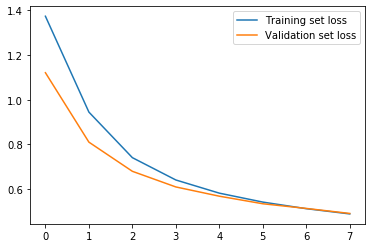

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt


def plot_history(history):
    plt.plot(history.history['loss'],label="Training set loss")
    plt.plot(history.history['val_loss'],label="Validation set loss")
    plt.legend()
    plt.show()


plot_history(history)

Seems to be leveling out a bit, but improving still with no signs of overfitting.

## Prediction

For prediction, we'll vectorize the given text normally, and initialize the decoder inputs to a vector with an initial start symbol and zeros otherwise.

We'll then predict outputs, take the first new predicted character, place that back into the decoder inputs, and iterate.

In [13]:
def predict(text):
    encoder_X = vectorize([text], input_tokenizer, INPUT_LENGTH, quiet=True)
    decoder_X = np.zeros(shape=(1, OUTPUT_LENGTH))
    decoder_X[0,0] = START_INDEX
    predictions = []
    for i in range(1, OUTPUT_LENGTH):
        prediction = model.predict([encoder_X, decoder_X])[0][i].argmax()
        predictions.append(prediction)
        decoder_X[0,i] = prediction
    pred_chars = []
    for i in predictions:
        if i == 0:
            break
        pred_chars += output_tokenizer.index_word[i]
    return ''.join(pred_chars)

Test with a few cases:

In [14]:
test_inputs = ['James', 'John', 'Robert', 'Mary', 'Patricia', 'Linda']
for text in test_inputs:
    print(text, predict(text))

James ジェームズ
John ジョン
Robert ロバート
Mary マリー
Patricia パトリキア
Linda リンダ
